
Author: Lok Yee Joey CHEUNG <br> 

# US Airline Passengers’ Satisfaction Analytics

Dataset: Klein, T. (2020, February 20). Airline passenger satisfaction. Kaggle. https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction/data 

Passengers’ satisfaction is critical when it comes to retaining customers and building a good image for an airline. Understanding different customers segments’ needs and analyzing the underlying drivers of customers’ satisfaction facilitates data-driven decision making and optimized resources allocation. 

This project aims at conducting Machine Learning tasks via Spark MLlib for feature importance detection, customer segmentation and building classification models regarding the satisfaction and flight classes of airline passengers in the United States. 

Reference: Practical 8 

### Imports and Set-ups

In [1]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, desc, stddev
from pyspark.ml.feature import StringIndexer,OneHotEncoder,VectorAssembler, StandardScaler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, NaiveBayes, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.linalg import Vectors
from pyspark.ml.functions import vector_to_array
from pyspark.ml.clustering import GaussianMixture

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.manifold import TSNE
from pyspark.sql.functions import mean
import pyspark.sql.functions as F

import matplotlib.pyplot as plt 
import seaborn as sb

In [2]:
#Create Spark Session and load datasets from hdfs 
spark = SparkSession.builder.appName("airline_satisfaction").config("spark.sql.debug.maxToStringFields", 100).config("spark.driver.memory", "15g").config("spark.executor.memory", "15g").getOrCreate()
df1 = spark.read.csv('hdfs://namenode/train.csv', header=True, inferSchema=True)
df2 = spark.read.csv('hdfs://namenode/test.csv', header=True, inferSchema=True)

### Data Cleaning

Remove the indexing columns:

In [3]:
#Combine two datasets
df = df1.union(df2)

In [4]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanline

In [5]:
#View the dataset as pandas dataframe
df.toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,129870,129871,129872,129873,129874,129875,129876,129877,129878,129879
_c0,0,1,2,3,4,5,6,7,8,9,...,25966,25967,25968,25969,25970,25971,25972,25973,25974,25975
id,70172,5047,110028,24026,119299,111157,82113,96462,79485,65725,...,30263,90347,86816,120654,25309,78463,71167,37675,90086,34799
Gender,Male,Male,Female,Female,Male,Female,Male,Female,Female,Male,...,Male,Female,Male,Male,Female,Male,Male,Female,Male,Female
Customer Type,Loyal Customer,disloyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,disloyal Customer,...,disloyal Customer,disloyal Customer,Loyal Customer,Loyal Customer,disloyal Customer,disloyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer
Age,13,25,26,25,61,26,47,52,41,20,...,42,39,41,52,36,34,23,17,14,42
Type of Travel,Personal Travel,Business travel,Business travel,Business travel,Business travel,Personal Travel,Personal Travel,Business travel,Business travel,Business travel,...,Business travel,Business travel,Business travel,Business travel,Business travel,Business travel,Business travel,Personal Travel,Business travel,Personal Travel
Class,Eco Plus,Business,Business,Business,Business,Eco,Eco,Business,Business,Eco,...,Eco,Business,Eco,Business,Eco,Business,Business,Eco,Business,Eco
Flight Distance,460,235,1142,562,214,1180,1276,2035,853,1061,...,1024,404,692,280,432,526,646,828,1127,264
Inflight wifi service,3,3,2,2,3,3,2,4,1,3,...,4,1,2,3,1,3,4,2,3,2
Departure/Arrival time convenient,4,2,2,5,3,4,4,3,2,3,...,4,1,2,3,5,3,4,5,3,5


In [6]:
#Drop index columns
df = df.drop("_c0","id")
df.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Departure Delay in Minutes: integer 

#### Remove null values:

In [7]:
#Check if there are null values for training set
null_counts = df.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts_dict = {col_name: null_count for col_name, null_count in null_counts.first().asDict().items()}

for col_name, count in null_counts_dict.items():
    print(f"Column '{col_name}': {count} null values")

Column 'Gender': 0 null values
Column 'Customer Type': 0 null values
Column 'Age': 0 null values
Column 'Type of Travel': 0 null values
Column 'Class': 0 null values
Column 'Flight Distance': 0 null values
Column 'Inflight wifi service': 0 null values
Column 'Departure/Arrival time convenient': 0 null values
Column 'Ease of Online booking': 0 null values
Column 'Gate location': 0 null values
Column 'Food and drink': 0 null values
Column 'Online boarding': 0 null values
Column 'Seat comfort': 0 null values
Column 'Inflight entertainment': 0 null values
Column 'On-board service': 0 null values
Column 'Leg room service': 0 null values
Column 'Baggage handling': 0 null values
Column 'Checkin service': 0 null values
Column 'Inflight service': 0 null values
Column 'Cleanliness': 0 null values
Column 'Departure Delay in Minutes': 0 null values
Column 'Arrival Delay in Minutes': 393 null values
Column 'satisfaction': 0 null values


In [8]:
#Remove null values
df = df.na.drop()

#### Remove duplicates:

In [9]:
#Remove duplicate rows
df = df.dropDuplicates()

#### Observe dataset:

In [10]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129487 non-null  object 
 1   Customer Type                      129487 non-null  object 
 2   Age                                129487 non-null  int32  
 3   Type of Travel                     129487 non-null  object 
 4   Class                              129487 non-null  object 
 5   Flight Distance                    129487 non-null  int32  
 6   Inflight wifi service              129487 non-null  int32  
 7   Departure/Arrival time convenient  129487 non-null  int32  
 8   Ease of Online booking             129487 non-null  int32  
 9   Gate location                      129487 non-null  int32  
 10  Food and drink                     129487 non-null  int32  
 11  Online boarding                    1294

It is observed that some columns are categorical while some are numerical. We would convert the categorical columns into numerical later on. 

### Exploratory Data Analysis

**Data distribution of target variable:**

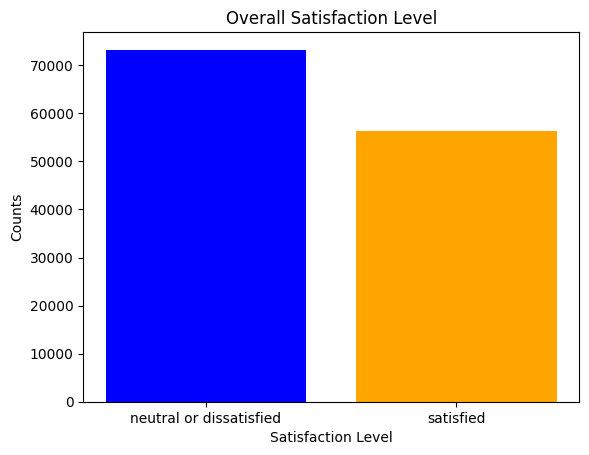

In [12]:
#Plot the Satisfaction level distribution
sat_counts = df.groupBy('satisfaction').count().orderBy('satisfaction')

satisfaction_levels = sat_counts.rdd.map(lambda row: row['satisfaction']).collect()
counts = sat_counts.rdd.map(lambda row: row['count']).collect()

colors = {'neutral or dissatisfied': 'blue', 'satisfied': 'orange'}

plt.bar(satisfaction_levels, counts, color=[colors[c] for c in satisfaction_levels])
plt.xlabel("Satisfaction Level")
plt.ylabel("Counts")
plt.title("Overall Satisfaction Level")
plt.show()

It is observed that the two classes are imbalanced. We then undersample the majority class 'neutral or dissatisfied' to balance the data.

In [11]:
#Undersampling the Majority Class

# Separate the majority and minority classes
majority_class = df.filter(df['satisfaction'] == 'neutral or dissatisfied')
minority_class = df.filter(df['satisfaction'] == 'satisfied')

# Calculate the ratio of majority to minority samples
ratio = minority_class.count() / majority_class.count()

# Sample a fraction of the majority class to match the minority class
# The sampling process is done without replacement and ratio is set to the ratio of minority samples to majority samples
undersampled_data = majority_class.sample(withReplacement=False, fraction=ratio, seed=42)

# Combine the undersampled majority class with the minority class
df = undersampled_data.unionAll(minority_class)

In [10]:
#Check the number of rows with satisfaction level of 'neutral or dissatisfied'
df.filter(df['satisfaction'] == 'neutral or dissatisfied').count()

56275

In [11]:
#Check the number of rows with satisfaction level of 'satisfied'
df.filter(df['satisfaction'] == 'satisfied').count()

56262

**Outlier detecting:**

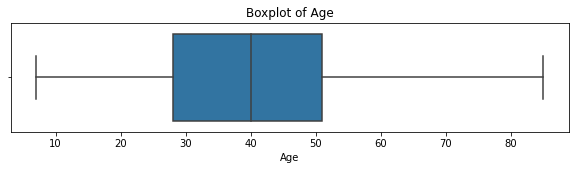

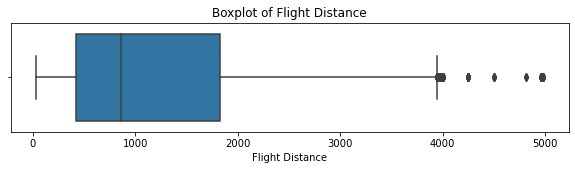

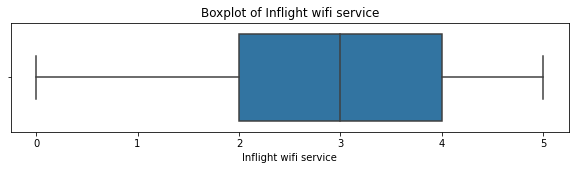

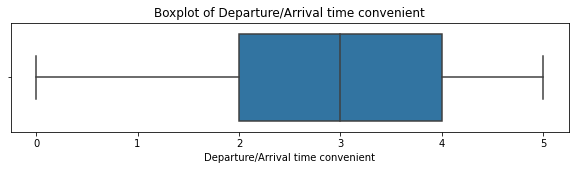

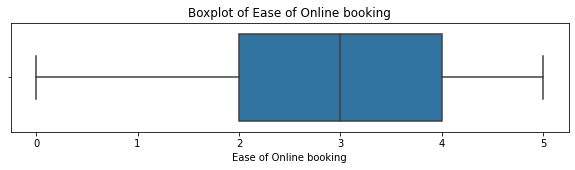

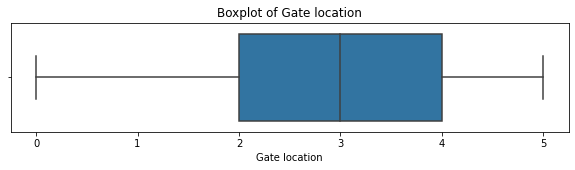

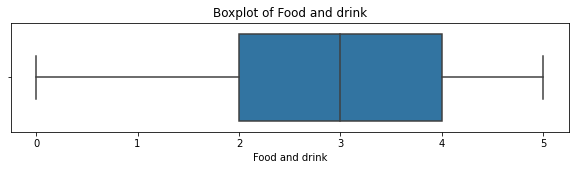

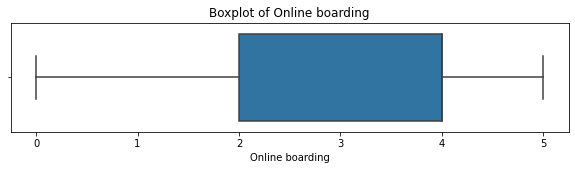

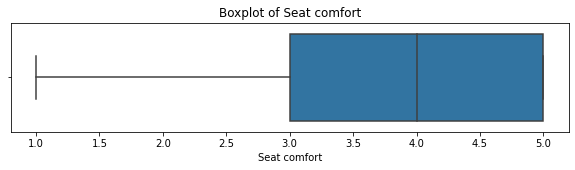

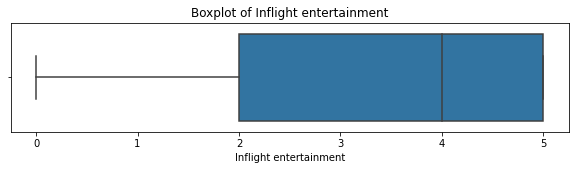

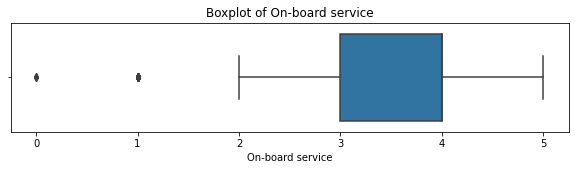

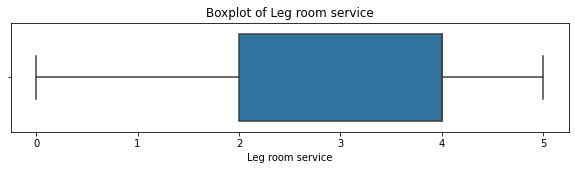

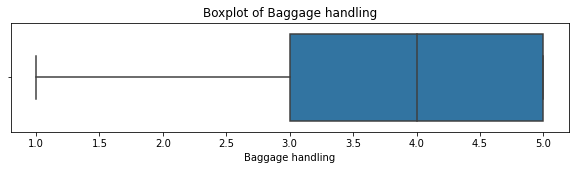

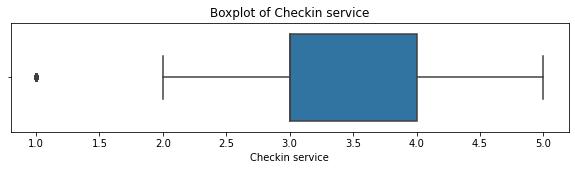

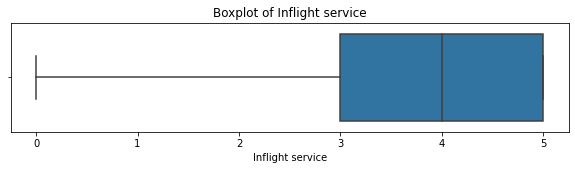

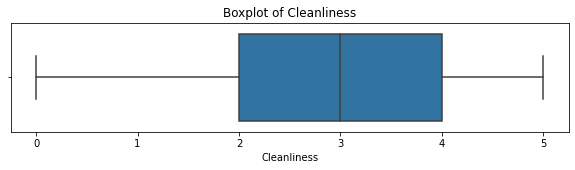

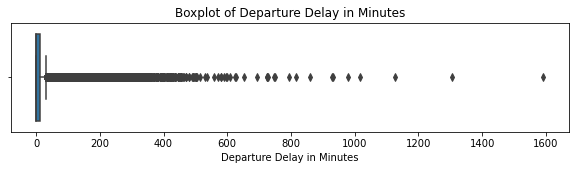

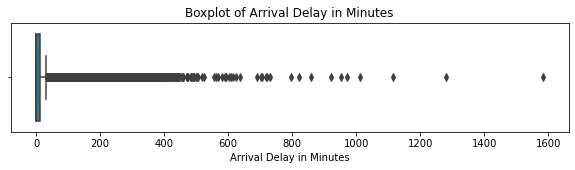

In [19]:
# Plot Box plots to detect outliers
df_numerics = [col_name for col_name, col_type in df.dtypes if col_type == 'int' or col_type == 'double']
df_pd = df.select(df_numerics).toPandas()

for col in df_numerics:
    plt.figure(figsize=(10, 2))
    sb.boxplot(x=df_pd[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [20]:
df.sort(desc("Arrival Delay in Minutes")).limit(10).toPandas()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,47,Personal Travel,Eco,1120,2,2,2,3,...,2,4,4,4,2,3,2,1592,1584.0,neutral or dissatisfied
1,Male,Loyal Customer,32,Business travel,Business,2916,2,2,2,2,...,3,4,5,4,5,3,5,1305,1280.0,satisfied
2,Male,Loyal Customer,8,Personal Travel,Eco,1144,2,5,2,2,...,4,4,3,5,1,3,1,1128,1115.0,neutral or dissatisfied
3,Male,Loyal Customer,49,Business travel,Business,1959,1,1,1,1,...,4,4,4,5,4,4,4,1017,1011.0,satisfied
4,Male,Loyal Customer,30,Personal Travel,Eco,1598,1,4,1,2,...,5,3,4,4,1,4,1,978,970.0,neutral or dissatisfied
5,Female,Loyal Customer,53,Business travel,Business,2418,3,4,4,4,...,3,5,2,2,3,4,3,930,952.0,neutral or dissatisfied
6,Male,Loyal Customer,47,Business travel,Business,2187,4,5,4,4,...,5,4,5,5,4,4,4,933,920.0,satisfied
7,Male,Loyal Customer,27,Business travel,Business,1746,1,1,4,1,...,4,3,5,4,5,4,5,859,860.0,satisfied
8,Female,Loyal Customer,42,Business travel,Business,693,2,1,1,1,...,2,5,3,3,2,4,2,815,822.0,neutral or dissatisfied
9,Female,Loyal Customer,45,Personal Travel,Eco,630,1,4,1,1,...,3,4,4,5,5,5,5,794,795.0,neutral or dissatisfied


It is noticed that there are several outliers regarding the delay in arrival time and departure time. After viewing the dataframe, we decided not to eliminate them as they do not seem to be human or measurement errors. It is possible that the delay is larger than 1000 minutes (approximately over 16 hours) which could contribute significantly to customers' satisfaction levels. 

**Correlation Analysis:**

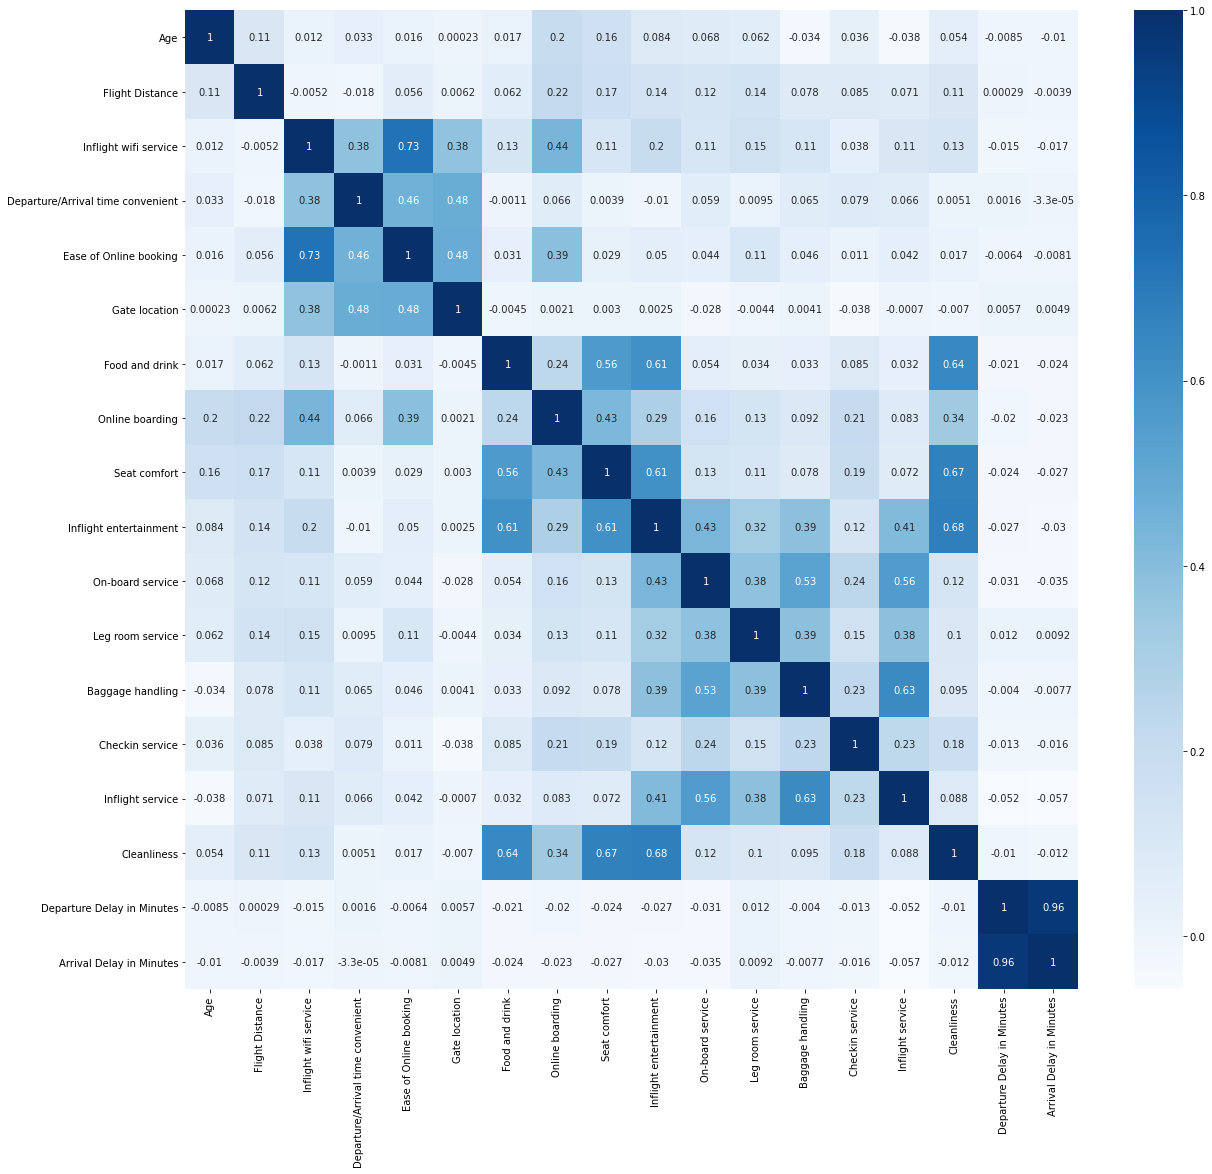

In [21]:
#Plot heatmap to see the correlations between variables 
df_numerics = [col_name for col_name, col_type in df.dtypes if col_type == 'int' or col_type == 'double']
f, ax = plt.subplots(figsize=(20, 18))
dataplot = sb.heatmap(df.select(df_numerics).toPandas().corr(), cmap="Blues", annot=True)
plt.show()

We observed that features "Departure Delay in Minutes" and "Arrival Delay in Minutes" are highly correlated. We decided to remove "Arrival Delay in Minutes" since its delay is directly caused by departure delay. 

In [12]:
#Drop highly correlated column
df = df.drop("Arrival Delay in Minutes")

**Check if there is a linear relationship between dependent and independent varibales:**

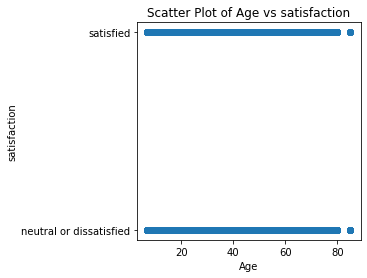

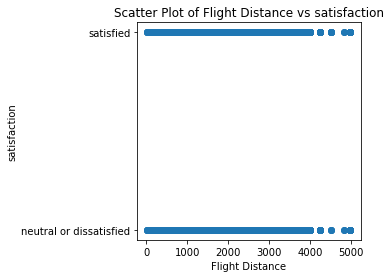

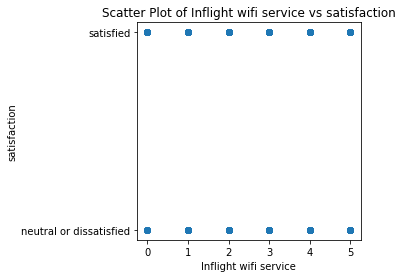

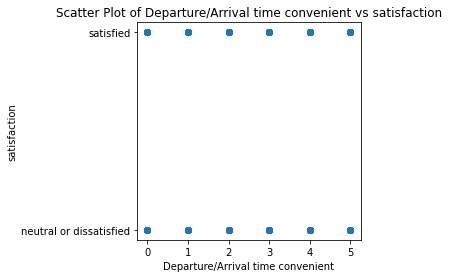

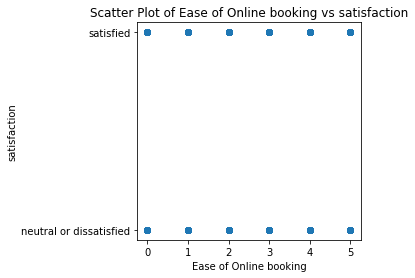

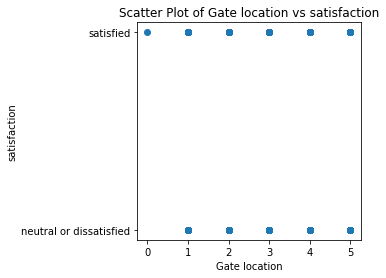

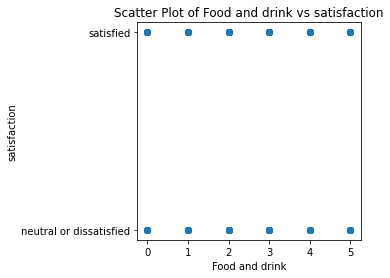

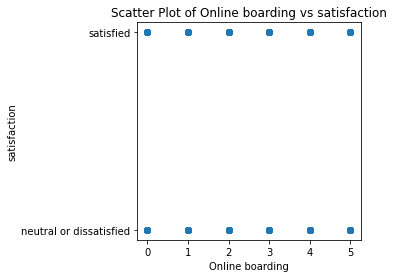

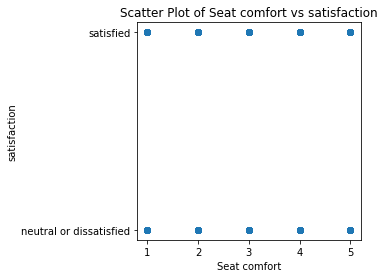

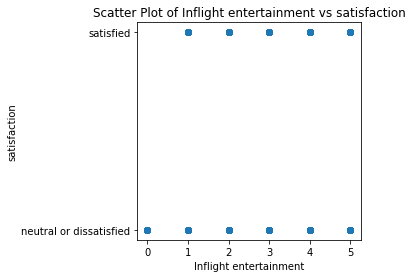

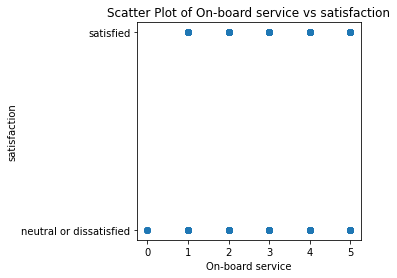

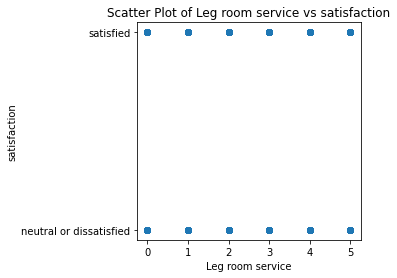

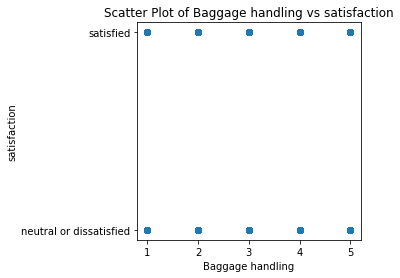

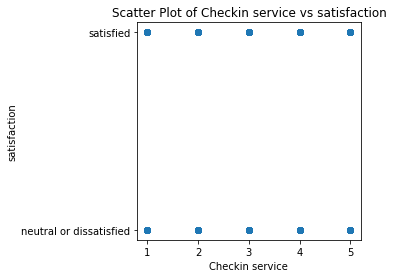

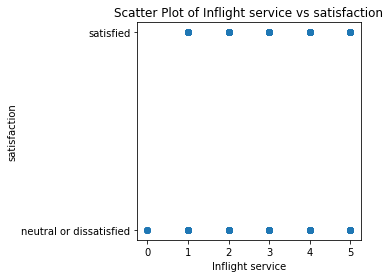

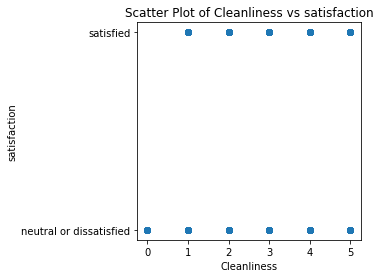

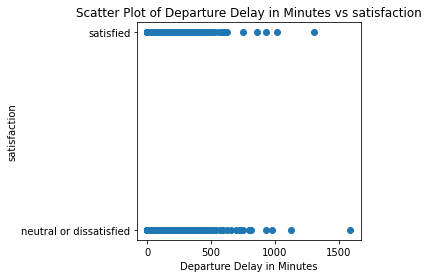

In [23]:
#Get numeric columns and define target column
df_numerics = df.select(*[col_name for col_name, col_type in df.dtypes if col_type == 'int' or col_type == 'double'])
target_col = 'satisfaction'

# Plot scattered plot to observe the relationships of numerical data
for col_name in df_numerics.columns:
    plt.figure(figsize=(4, 4))
    plt.scatter(df.select(col_name).rdd.map(lambda x: x[0]).collect(), df.select(target_col).rdd.map(lambda x: x[0]).collect())
    plt.xlabel(col_name)
    plt.ylabel(target_col)
    plt.title(f"Scatter Plot of {col_name} vs {target_col}")
    plt.show()

Non-linear relationships are observed. 

### Feature Engineering:

#### Encode Object columns into Integers:

Specify two types of columns:

In [13]:
#Get list of columns names which contain strings as data type
df_obj = [col_name for col_name, col_type in df.dtypes if col_type == "string"]

#Get list of columns names which contain integer or floating numbers as data type
df_numerics = [col_name for col_name, col_type in df.dtypes if col_type == 'int' or col_type == 'double']

With the use of StringIndexer, we transform each of them to encoded variables below. Afterwards, VectorAssembler is used to combine all features into a single vector column. Chain the workflow into a pipeline's stages. The procedures are as follows:

In [14]:
stages =[]
for categoricalCol in df_obj:
    # Index each string column using StringIndexer
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_encoded')
    
    # Convert each indexed column into one-hot encoded variables
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])

    # Chain workflow in stages
    stages += [stringIndexer, encoder]

#### Assemble the selected columns into a feature vector:

In [15]:
#Define input columns by removing labelled columns
assemblerInputs = [c + "classVec" for c in df_obj if c != 'satisfaction'] + df_numerics
print(assemblerInputs)

['GenderclassVec', 'Customer TypeclassVec', 'Type of TravelclassVec', 'ClassclassVec', 'Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes']


In [16]:
#Create a vector assembler to assemble the selected columns into a feature vector
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Above transformations could be implemented following the ordered stages in Pipeline:

In [17]:
#Perform above transformations workflow in a roll by using pipeline
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df_2 = pipelineModel.transform(df)

In [29]:
pd.DataFrame(df_2.take(5), columns=df_2.columns).transpose()

,0,1,2,3,4
Gender,Female,Male,Female,Male,Male
Customer Type,Loyal Customer,disloyal Customer,disloyal Customer,Loyal Customer,Loyal Customer
Age,9,40,54,9,47
Type of Travel,Personal Travel,Business travel,Business travel,Personal Travel,Business travel
Class,Eco,Business,Business,Eco,Business
Flight Distance,687,857,862,483,526
Inflight wifi service,2,2,2,2,2
Departure/Arrival time convenient,5,2,2,5,4
Ease of Online booking,2,2,2,2,4
Gate location,3,3,3,2,4


#### Normalise the features using StandardsScaler:

In [18]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_2)
scaled_df = scaler_model.transform(df_2)

#### Get the final dataframe for model implementation:

In [19]:
#Create final dataframe for model
selectedCols = ['satisfaction_encoded', 'scaled_features'] + cols
df_encoded = scaled_df.select(selectedCols)
df_encoded.printSchema()

root
 |-- satisfaction_encoded: double (nullable = false)
 |-- scaled_features: vector (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nu

#### Splitting into training and testing sets:

In [20]:
#Split data into train/test set
training_data, testing_data = df_encoded.randomSplit([0.7,0.3], seed = 42)

### Big Data Analytics Task 1: Rank the importance of the features contributing to passengers' satisfaction levels

### Random Forest 

We implement Random Forest to **investigate which features in the dataset contribute greater to passengers' satisfactions**. By observing the possible leading factors, airline companies could make better decisions on their future improvement strategies on their services.  

In [175]:
#Create Random Forest model
rf = RandomForestClassifier(featuresCol='scaled_features', labelCol='satisfaction_encoded', numTrees=10)

In [176]:
#Train the Random Forest model and perform prediction on test data
rf_model = rf.fit(training_data)
rf_pred = rf_model.transform(testing_data)

In [19]:
#Finding the feature importances using Gini importance in Random Forest
feature_importances = rf_model.featureImportances
feature_importances

SparseVector(22, {0: 0.0004, 1: 0.0198, 2: 0.1061, 3: 0.1684, 4: 0.0079, 5: 0.0016, 6: 0.0272, 7: 0.1356, 8: 0.0013, 9: 0.0445, 10: 0.0, 11: 0.0036, 12: 0.2766, 13: 0.0516, 14: 0.0799, 15: 0.0148, 16: 0.0296, 17: 0.0034, 18: 0.0054, 19: 0.0021, 20: 0.0199, 21: 0.0001})

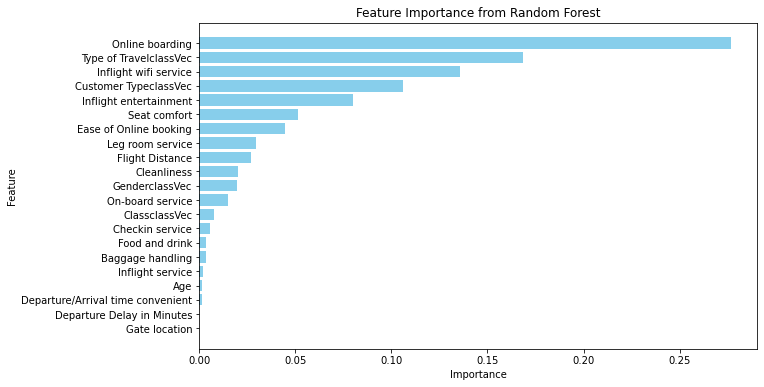

In [20]:
# Convert the SparseVector to a Pandas DataFrame for easy plotting
feature_importance_df = pd.DataFrame({'Feature': assemblerInputs, 'Importance': feature_importances.toArray()[1:]})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

With the use of Gini importance in Random forest, the output graph shows the resulted ranking of features importance. According to Apache Spark's website, each feature's importance is calculated by the average of its importance across all trees in the ensemble. All features' importance are represented as a vector which is normalized sum of 1.The higher the importance, the larger the feature contributes to the satisfaction level. Type of travel, Online boarding, Customer Type and Inflight wifi service have relatively bigger impacts on customers' satisfaction. 

### Big Data Analytics Task 2: Satisfaction Prediction

We build binary classification models for **predicting passengers’ satisfaction levels**, whether customers are ‘satisfied’ or ‘neutral or dissatisfied’ with the airlines. Since companies' performance is reflected in the customers' feedback, more data-driven decisions could be facilitated e.g. personalized services to improve customers' experiences. 

### Logistic Regression

In [23]:
#Create logistic regression model
lr = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'satisfaction_encoded', maxIter=10)

In [25]:
#Train thelogistic regression model and perform prediction on test data
lr_model = lr.fit(training_data)
lr_pred =lr_model.transform(testing_data)

#### Evaluation:
We used Binary Classification Evaluator to validate the model using Area under ROC curve. By tunning the mode by with different combinations of hyperparameters, we performed K-fold Cross-validation.

In [27]:
#Create Binary Classification Evaluator object
evaluator = BinaryClassificationEvaluator(labelCol='satisfaction_encoded')

#Find area under ROC and PR to evaluate the performance of the logistic regression model
areaUnderROC = evaluator.evaluate(lr_pred, {evaluator.metricName: "areaUnderROC"})
areaUnderPR = evaluator.evaluate(lr_pred, {evaluator.metricName: "areaUnderPR"})
print(f"Area under ROC Curve: {areaUnderROC}")
print(f"Area under PR Curve: {areaUnderPR}")

Area under ROC Curve: 0.925759596849181
Area under PR Curve: 0.9417864685762055


In [28]:
#Tune the model using ParamGridBuilder and perform 5-fold Cross validation 
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(training_data)
predictions = cvModel.transform(testing_data)

best_regParam = cvModel.bestModel.getOrDefault('regParam')
best_elasticNetParam = cvModel.bestModel.getOrDefault('elasticNetParam')
best_maxIter = cvModel.bestModel.getOrDefault('maxIter')
print(f"Best regParam:{best_regParam}; Best elasticNetParam:{best_elasticNetParam}; Best maxIter:{best_maxIter}")
print("Test AUC:", evaluator.evaluate(predictions))

Best regParam:0.01; Best elasticNetParam:0.0; Best maxIter:5
Test AUC: 0.9256191188441459


The ROC curve demonstrated a good trade-off between true positive and false positive rates, with an AUC of 0.93.

### Random Forest

In [42]:
#Create Random Forest model
rf = RandomForestClassifier(featuresCol='scaled_features', labelCol='satisfaction_encoded', numTrees=10)

#Train the Random Forest model and perform prediction on test data
rf_model = rf.fit(training_data)
rf_pred = rf_model.transform(testing_data)

#### Evaluation:


We used Binary Classification Evaluator to validate the model using Area under ROC curve. By tunning the mode by with different combinations of hyperparameters, we performed K-fold Cross-validation.

In [23]:
#Find area under ROC and PR to evaluate the performance of the logistic regression model
evaluator = BinaryClassificationEvaluator(labelCol='satisfaction_encoded')
areaUnderROC = evaluator.evaluate(rf_pred, {evaluator.metricName: "areaUnderROC"})
areaUnderPR = evaluator.evaluate(rf_pred, {evaluator.metricName: "areaUnderPR"})
print(f"Area under ROC Curve: {areaUnderROC}")
print(f"Area under PR Curve: {areaUnderPR}")

Area under ROC Curve: 0.9681307941781819
Area under PR Curve: 0.9681231081776909


Random Forest aggregates predictions from multiple decision trees using bagging and hence a better generalization to unseen data than decision tree.

In [30]:
#Tune the model using ParamGridBuilder and perform 5-fold Cross validation 
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [10, 20])
             .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(training_data)
predictions = cvModel.transform(testing_data)

best_maxDepth = cvModel.bestModel.getOrDefault('maxDepth')
best_maxBins = cvModel.bestModel.getOrDefault('maxBins')
best_numTrees = cvModel.bestModel.getOrDefault('numTrees')
print(f"Best maxDepth:{best_maxDepth}; Best maxBins:{best_maxBins}; Best numTrees:{best_numTrees}")
print("Test AUC:", evaluator.evaluate(predictions))

Best maxDepth:6; Best maxBins:60; Best numTrees:10
Test AUC: 0.9750691160499798


### Gradient Boosted Tree

In [43]:
#Train the GBT model and perform prediction on test data
gbt = GBTClassifier(featuresCol='scaled_features', labelCol='satisfaction_encoded', maxIter=10)
gbt_model = gbt.fit(training_data)
gbt_pred = gbt_model.transform(testing_data)

#### Evaluation:
We used Binary Classification Evaluator to validate the model using Area under ROC curve. By tunning the mode by with different combinations of hyperparameters, we performed K-fold Cross-validation.

In [25]:
#Find area under ROC and PR to evaluate the performance of the logistic regression model
evaluator = BinaryClassificationEvaluator(labelCol='satisfaction_encoded')
areaUnderROC = evaluator.evaluate(gbt_pred, {evaluator.metricName: "areaUnderROC"})
areaUnderPR = evaluator.evaluate(gbt_pred, {evaluator.metricName: "areaUnderPR"})
print(f"Area under ROC Curve: {areaUnderROC}")
print(f"Area under PR Curve: {areaUnderPR}")

Area under ROC Curve: 0.9807424531869466
Area under PR Curve: 0.9823605900067358


In [26]:
#Tune the model using ParamGridBuilder and perform 5-fold Cross validation 
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(training_data)
predictions = cvModel.transform(testing_data)

best_maxDepth = cvModel.bestModel.getOrDefault('maxDepth')
best_maxBins = cvModel.bestModel.getOrDefault('maxBins')
best_maxIter = cvModel.bestModel.getOrDefault('maxIter')
print(f"Best maxDepth:{best_maxDepth}; Best maxBins:{best_maxBins}; Best maxIter:{best_maxIter}")
print("Test AUC:", evaluator.evaluate(predictions))

Best maxDepth:6; Best maxBins:20; Best maxIter:20
Test AUC: 0.989012555902338


Gradient Boosted Tree achieved the best result with cross validation AUC reaching 0.988.

#### Visualization - Models Comparison:

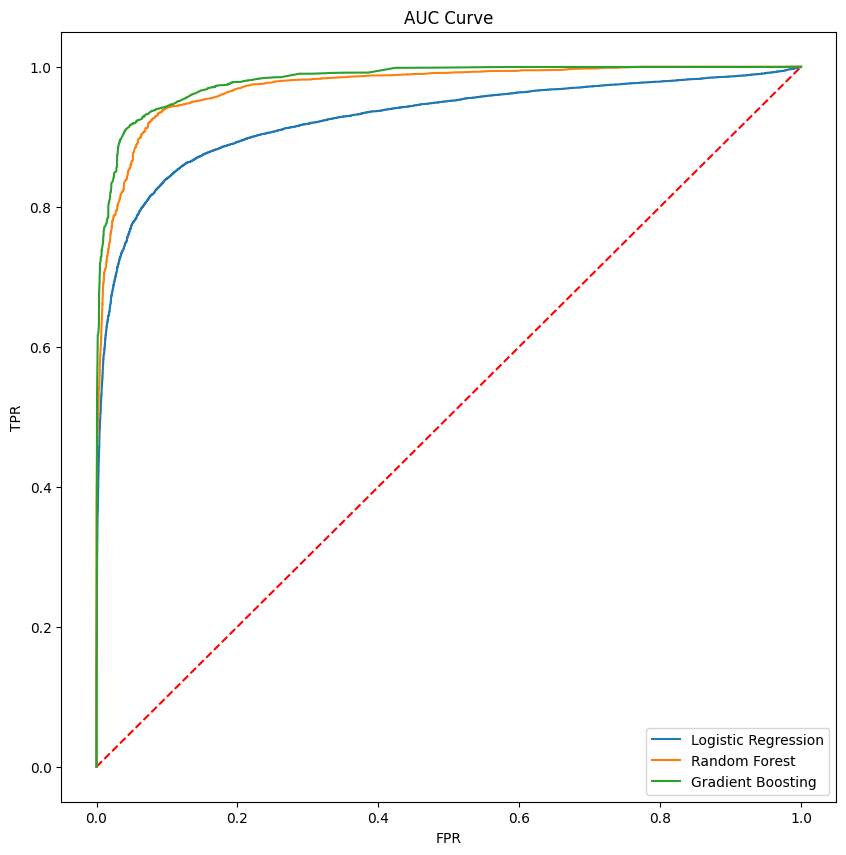

AUC of LR = 0.9257593271834157
AUC of RF = 0.9724883932461493
AUC of GBT = 0.9812422654590226


In [182]:
#Get the FPR and TPR of each model
y_score_lr = lr_pred.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_true_lr = lr_pred.select("satisfaction_encoded").rdd.keys().collect()
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_true_lr, y_score_lr)

y_score_rf = rf_pred.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_true_rf = rf_pred.select("satisfaction_encoded").rdd.keys().collect()
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true_rf , y_score_rf)

y_score_gbt = gbt_pred.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_true_gbt = gbt_pred.select("satisfaction_encoded").rdd.keys().collect()
fpr_gbt, tpr_gbt, thresholds_gbt = roc_curve(y_true_gbt , y_score_gbt)

#Plot the ROC curve of the 4 models
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_lr,tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf,tpr_rf, label="Random Forest")
plt.plot(fpr_gbt,tpr_gbt, label="Gradient Boosting")
plt.title("AUC Curve")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()

# Calculate AUC
print("AUC of LR = %s" % evaluator.evaluate(lr_pred))
print("AUC of RF = %s" % evaluator.evaluate(rf_pred))
print("AUC of GBT = %s" % evaluator.evaluate(gbt_pred))

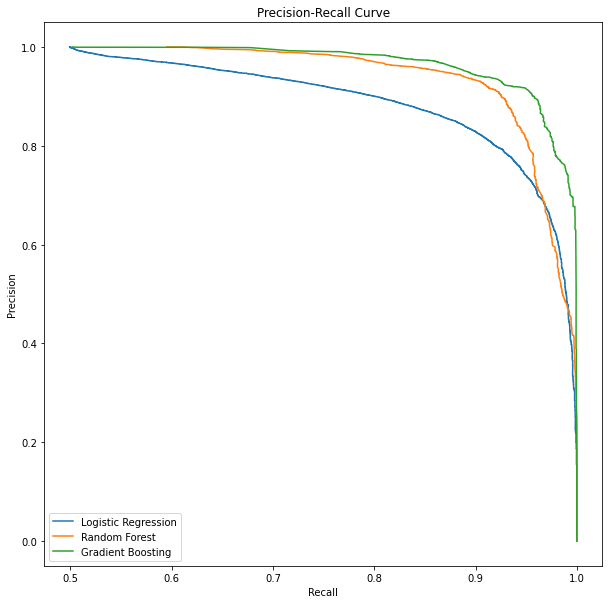

Area under Precision-Recall Curve of LR = 0.941574901917643
Area under Precision-Recall Curve of RF = 0.9681082437606368
Area under Precision-Recall Curve of GBT = 0.9823605900067358


In [27]:
#Retrieve the precision and recall of each model
pre_lr,recall_lr, thresholds_lr = precision_recall_curve(y_true_lr, y_score_lr)
pre_rf,recall_rf, thresholds_rf = precision_recall_curve(y_true_rf , y_score_rf)
pre_gbt,recall_gbt, thresholds_gbt = precision_recall_curve(y_true_gbt , y_score_gbt)

#Plot the ROC curve of the 4 models
plt.figure(figsize=(10,10))
plt.plot(pre_lr,recall_lr, label="Logistic Regression")
plt.plot(pre_rf,recall_rf, label="Random Forest")
plt.plot(pre_gbt,recall_gbt, label="Gradient Boosting")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

print("Area under Precision-Recall Curve of LR = %s" % auc(recall_lr, pre_lr))
print("Area under Precision-Recall Curve of RF = %s" % auc(recall_rf, pre_rf))
print("Area under Precision-Recall Curve of GBT = %s" % auc(recall_gbt, pre_gbt))

Gradient Boosting outperforms the others in both AUC and area under PR curve in the prediction of satisfaction levels of airline passengers. Both ensemble methods are more efficient in handling large dataset while logistic regression may underperform a bit due to the fact that the relationships between features are not mostly linear.

### Big Data Analytics Task 3: Airline Classes Prediction

Here, we perform **multi-class prediction of airline passengers' classes (Eco, Eco plus, Business)** using Decision Tree and Random Forest. Airline companies could provide tailored services to VIPs or regular customers such as seat arrangements, upgrade services etc. in order to build up customers' loyalty. Benefits like price strategies optimization and better resources allocation could also be faciliated by predicting future demands.

#### Data Preprocessing:

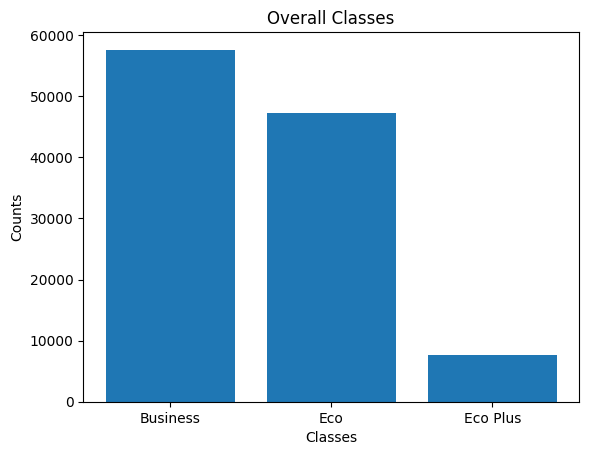

In [100]:
#Plot the Classes distribution
sat_counts = df.groupBy('Class').count().orderBy('Class')

class_count = sat_counts.rdd.map(lambda row: row['Class']).collect()
counts = sat_counts.rdd.map(lambda row: row['count']).collect()

plt.bar(class_count, counts)
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("Overall Classes")
plt.show()

Classes are heavily imbalanced. Undersampling the majority class is needed.

In [27]:
#Undersampling the Majority Classes

# Separate the majority and minority classes
majority_classA = df.filter(df['Class'] == 'Business')
classB = df.filter(df['Class'] == 'Eco')
classC = df.filter(df['Class'] == 'Eco Plus')

# Calculate the ratio of majority to minority samples
ratio_A = classC.count() / majority_classA.count()
ratio_B = classC.count() / classB.count()
ratio_C = majority_classA.count() / classC.count()

# Sample a fraction of the majority class for each class
undersampled_class_A = majority_classA.sample(withReplacement=False, fraction=min(ratio_A, 1.0), seed=42)
undersampled_class_B = classB.sample(withReplacement=False, fraction=min(ratio_B, 1.0), seed=42)
undersampled_class_C = classC.sample(withReplacement=False, fraction=min(ratio_C, 1.0), seed=42)

# Combine the undersampled classes with the original minority classes
df_class = undersampled_class_A.unionAll(undersampled_class_B).unionAll(undersampled_class_C)


In [150]:
#Check the number of rows of each class
print("Business class: ",df_class.filter(df_class['Class'] == 'Business').count())
print("Economy class: ",df_class.filter(df_class['Class'] == 'Eco').count())
print("Economy Plus class: ",df_class.filter(df_class['Class'] == 'Eco Plus').count())


Business class:  7776
Economy class:  7966
Economy Plus class:  7800


#### Encode Object columns into Integers and assemble the selected columns into feature vectors:

In [28]:
stages =[]
for categoricalCol in df_obj:
    # Index each string column using StringIndexer
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_encoded')
    
    # Convert each indexed column into one-hot encoded variables
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])

    # Chain workflow in stages
    stages += [stringIndexer, encoder]

In [29]:
#Create a vector assembler to assemble the selected columns into a feature vector
assemblerinputs = [c + "classVec" for c in df_obj if c != 'satisfaction' and c != 'Class'] + df_numerics
assembler = VectorAssembler(inputCols=assemblerinputs, outputCol="features")
stages +=[assembler]

In [30]:
# Perform transformation in pipeline
cols = df_class.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_class)
df_3 = pipelineModel.transform(df_class)

#Perform normalization 
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_3)
scaled_df2 = scaler_model.transform(df_3)

In [31]:
#Create final dataframe for model building 
selectedCols = ['class_encoded', 'scaled_features'] + cols
df_encoded2 = scaled_df2.select(selectedCols)
df_encoded2.printSchema()

root
 |-- class_encoded: double (nullable = false)
 |-- scaled_features: vector (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable 

In [32]:
#Split data into train/test set
training_data, testing_data = df_encoded2.randomSplit([0.7,0.3], seed = 42)

### Decision Tree

In [33]:
#Create Decision Tree model
dt = DecisionTreeClassifier(featuresCol = 'scaled_features', labelCol = 'class_encoded', maxDepth = 7)

In [34]:
#Train the Decision Tree model and perform prediction on test data
dt_model = dt.fit(training_data)
dt_pred = dt_model.transform(testing_data)

#### Evaluation:
We used Multiclass Classification Evaluator to validate the model using Area under ROC curve. By tunning the mode by with different combinations of hyperparameters, we performed K-fold Cross-validation.

In [36]:
#Find accuracy, precision, recall and F1 to evaluate the performance of the decision tree model
eval_accuracy = MulticlassClassificationEvaluator(labelCol='class_encoded', predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol='class_encoded', predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol='class_encoded', predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol='class_encoded', predictionCol="prediction", metricName="f1")

results_df = pd.DataFrame({
    'metrics': ['Accuracy',"Prediction", "Recall",'F1'],
    'Decision Tree':[eval_accuracy.evaluate(dt_pred),eval_precision.evaluate(dt_pred)
                     ,eval_recall.evaluate(dt_pred),eval_f1.evaluate(dt_pred)]
})

results_df = results_df.set_index('metrics', drop=True) 
results_df.T

metrics,Accuracy,Prediction,Recall,F1
Decision Tree,0.650087,0.565523,0.622051,0.648836


The accuracy and F1 score of the decision tree model reaches 65%. This is reasonable since the majority of the columns are used for the classification of our major target, satisfaction. The prediction of classes may need more new features of the passengers in order to produce a higher performance prediction. 

In [ ]:
#Tune the model using ParamGridBuilder and perform 5-fold Cross validation 
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 4, 6])
             .addGrid(dt.maxBins, [20, 60])
             .build())

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=eval_accuracy, numFolds=5)

cvModel = cv.fit(training_data)
predictions = cvModel.transform(testing_data)

best_maxDepth = cvModel.bestModel.getOrDefault('maxDepth')
best_maxBins = cvModel.bestModel.getOrDefault('maxBins')

In [38]:
print(f"Best maxDepth:{best_maxDepth}; Best maxBins:{best_maxBins}")
print('Test Accuracy:', eval_accuracy.evaluate(predictions))

Best maxDepth:6; Best maxBins:60
Test Accuracy: 0.6247099767981439


The model achieved an average accuracy of 63% across the k folds, indicating that 63% of the predictions were correct on average.

### Big Data Analytics Task 4: Customers Segmentation

We **carry out Clustering to group customers into different segments**. We gain insights by identifying common characteristics of different customers segments e.g. age groups associated with their travel behaviours. This faciliates the decision-making process of target marketing strategies or loyalty programs more effectively.

In [21]:
columns_to_keep = [col for col in scaled_df.columns if col not in df_obj]
cluster_df = scaled_df.select(columns_to_keep)

### Gaussian Mixture

GMM uses a probabilistic modelling to assign data points to different clusters. It is more robust to handle outliers and allows for more flexible cluster shapes by modeling them as ellipses with different variances.

In [22]:
#Define the number of clusters
k=3

#Train and cluster the data using GMM model
gmm = GaussianMixture(featuresCol = 'scaled_features').setK(k).setSeed(538009335)
model = gmm.fit(cluster_df)
clustered_data = model.transform(cluster_df)

The number of data points assigned to each cluster:

In [23]:
# See the number of data points in each cluster
clustered_data.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|30959|
|         2|33522|
|         0|48056|
+----------+-----+



We may future look at the statistic summary of each cluster:

In [24]:
#Perform analysis using statistics
cluster_summary = clustered_data.groupBy("prediction").agg(
    mean("Age").alias("mean_Age"),
    F.expr('percentile_approx(Gender_encoded, 0.5)').alias("median_Gender"),
    F.expr('percentile_approx(Class_encoded, 0.5)').alias("median_Class"),
    mean("Flight distance").alias("mean_FlightDistance"),
    mean("Departure Delay in Minutes").alias("mean_DepartureDelay"),
    F.expr('percentile_approx(`Seat Comfort`, 0.5)').alias("median_SeatComfort"),
    F.expr('percentile_approx(`Online Boarding`, 0.5)').alias("median_OnlineBoarding"),
    F.expr('percentile_approx(`Inflight entertainment`, 0.5)').alias("median_InflightEntertainment"),
    F.expr('percentile_approx(`Cleanliness`, 0.5)').alias("median_Cleanliness")

)
cluster_summary = cluster_summary.toPandas()
cluster_summary.set_index('prediction',inplace=True)
cluster_summary

,mean_Age,median_Gender,median_Class,mean_FlightDistance,mean_DepartureDelay,median_SeatComfort,median_OnlineBoarding,median_InflightEntertainment,median_Cleanliness
prediction,,,,,,,,,
1,33.114732,1.0,1.0,880.055267,14.070287,3,3,3,3
2,33.048625,1.0,1.0,957.648499,17.296015,3,3,3,3
0,48.598302,0.0,0.0,1645.482895,12.470222,4,4,4,4


When k=3, Cluster 0 are mostly people of older age, frequent Business Class customers (Class=0)  with relatively longer flight distance in average. Most of them value most services in the airline to a higher extent e.g. online boarding, seat comfort etc.
Cluster 1 and 2 are quite similar, with clusters of younger customers. It is also observed that younger customers usually takes Economy Class (Class=1) and are mostly Male (Gender=1).
3 clusters may not be the optimal number of segmentation since Group 1 and 2 are of similar characteristics. 

#### Dimensionality reduction

t-SNE is a non-linear dimensionality reduction technique that emphasizes preserving pairwise similarities between data points. It's particularly useful for visualizing clusters in lower-dimensional space.

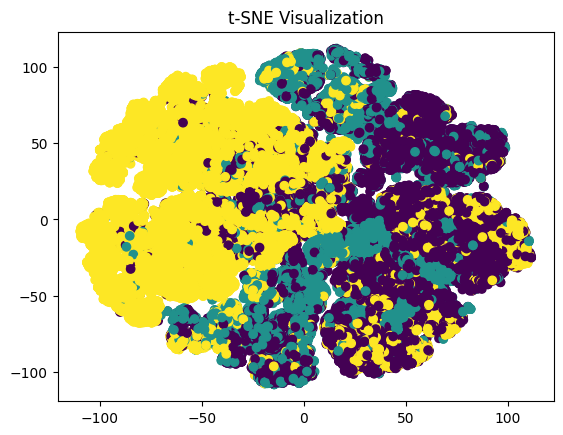

In [74]:
cluster_labels = clustered_data.select("prediction").rdd.flatMap(lambda x: x).collect()
cluster_pd = cluster_df.select("scaled_features").toPandas()
features_array = np.array(list(cluster_pd["scaled_features"]))

# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data using t-SNE
tsne_result = tsne.fit_transform(features_array)

# Create a scatter plot for visualization
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels) 
plt.title("t-SNE Visualization")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

The separation of cluster in the above graph is okay. It may not be the best well-separated cluster since overlapping data points from different clusters are clearly seen. This may be due to inherent data overlapping since the dataset contains survey results which leads to overlapping values in the original dataset. Most importantly, it succeeded in projecting and visualizing clusters with high dimensional features into low-dimensional space.